In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_parquet('../../data/box_builder_dataset/feature_frame.parquet')
df = pd.read_parquet('../../data/box_builder_dataset/feature_frame.parquet')

Let's remember what whe had in the previous task. This is the dataframe information and a sample of the data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


## Preparing the dataset

To get the lenght of the orders, we have to get the products with `outcome` = 1, which means that they were ordered.

In [5]:
ordered = df[df['outcome'] == 1]

We need to get the orders with at least 5 products

First we need to group the data by order_id and count the number of products in each order. Then we filter the orders with at least 5 products.

In [6]:
orders_len = ordered.groupby('order_id')['variant_id'].count()
orders_len.describe()

count    3427.000000
mean        9.697111
std         6.789204
min         1.000000
25%         5.000000
50%         9.000000
75%        13.000000
max        78.000000
Name: variant_id, dtype: float64

In [7]:
orders_over_eq_5 = orders_len[orders_len >= 5].index

In [8]:
df = df[df['order_id'].isin(orders_over_eq_5)]

In [9]:
df.shape

(2163953, 27)

In [10]:
df['variant_id'].nunique()

976

Now we have reduced the size of the dataset getting only the orders with at least 5 products. We can now start thinking about the next steps.

## Model building

Build a linear model that, given a user and a product, predicts if the
user would purchase it if they were buying with us at that point in time.

The model may be based on logistic regression. 
It should predict if a user would buy a product or not, which is a binary outcome.
On the dataset we have a variable that contains this value, `outcome`, so we can use it as the target variable.

A first approach to the model could be to use the following features:
- times_ordered
- abandoned_before
- active_snoozed
- set_as_regular
- global_popularity
- days_to_purchase_variant_id_norm  * ordered_before = ((days_since_last_purchase_variant_id - avg_days_to_buy_variant_id) / std_days_to_buy_variant_id)  * ordered_before
- days_to_purchase_product_type_norm = (days_since_last_purchase_product_type - avg_days_to_buy_product_type) / std_days_to_buy_product_type

We can start with these features and then add or remove some of them to see if the model improves.


The model would look like this:

$$
log(\frac{p}{1-p}) = \beta_0 + \beta_1 \cdot times\_ordered + \beta_2 \cdot abandoned\_before + \\
+ \beta_3 \cdot active\_snoozed + \beta_4 \cdot set\_as\_regular + \beta_5 \cdot global\_popularity + \\
+ \beta_6 \cdot days\_to\_purchase\_variant\_id\_norm \cdot ordered\_before + \\
+ \beta_7 \cdot days\_to\_purchase\_product\_type\_norm
$$

In [11]:
features = ['times_ordered', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'global_popularity', 'days_to_purchase_variant_id_norm', 'days_to_purchase_variant_id_if_ordered_before', 'days_to_purchase_product_type_norm']

Now we have to create the variables that we are going to use in the model if we don't have them already.

One approach to create the dataframe is get only one row for each user-product pair, and then add the features to the dataframe. This way we can use the user-product pair as the index of the dataframe and the outcome as the target variable.

In [12]:
df_sorted = df.sort_values(by=['user_id', 'order_date'], ascending=[True, False])

In [13]:
last_variant_df = df_sorted.groupby(['user_id', 'variant_id']).first().reset_index()

Now we have a dataframe where we have a row for each user-product pair using the last time the user bought the product. We can now add the features to the dataframe.

Let's start by adding the `times_ordered` feature. We can use the `groupby` method to get the number of times the user bought the product.

In [14]:
times_ordered = df.groupby(['user_id', 'variant_id'])['outcome'].sum().reset_index().rename(columns={'outcome': 'times_ordered'})

In [15]:
last_variant_df = last_variant_df.merge(times_ordered, on=['user_id', 'variant_id'], how='left')

The next features are `days_to_purchase_variant_id_norm` and `days_to_purchase_product_type_norm`. We can use the formula mentioned before to get them.

In [16]:
last_variant_df['days_to_purchase_variant_id_norm'] = (last_variant_df['avg_days_to_buy_variant_id'] - last_variant_df['days_since_purchase_variant_id']) / last_variant_df['std_days_to_buy_variant_id']

last_variant_df['days_to_purchase_variant_id_if_ordered_before'] = last_variant_df['days_to_purchase_variant_id_norm'] * last_variant_df['ordered_before']

In [17]:
last_variant_df['days_to_purchase_product_type_norm'] = (last_variant_df['avg_days_to_buy_product_type'] - last_variant_df['days_since_purchase_product_type']) / last_variant_df['std_days_to_buy_product_type']

Let's create the final dataframe with the features and the target variable. Then we can build the model and evaluate it.

In [18]:
final_df = last_variant_df[['user_id', 'variant_id', 'outcome', *features]].copy()

First we set an alias for the input data and the target variable.

In [19]:
X = last_variant_df[features].copy()
y = last_variant_df['outcome'].copy()

Make ANOVA analysis to check if the variables selected have a significant impact into the target variable.

In [20]:
from sklearn.feature_selection import f_classif

In [21]:
f_statistic, p_values = f_classif(X, y)

In [22]:
print(f_statistic.round(4))
print(p_values.round(10))

[1.71556534e+06 3.24707399e+04 2.03372920e+03 3.03256850e+04
 2.91691156e+04 3.88974500e+02 4.52221550e+03 2.08378100e+02]
[0. 0. 0. 0. 0. 0. 0. 0.]


As we can see in the p-values, all the variables have a significant impact on the target variable. We can use them to build the model.

It's time to split the data into training, validation and test sets. We can use the `train_test_split` method from the `sklearn` library to do this.

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# 0.3 x 0.7 = 0.21 validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

Now we can build the model using the training set and evaluate it using the validation set.

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [28]:
y_val_pred = model.predict(X_val)
y_val_pred_prob = model.predict_proba(X_val)[:, 1]

Let's see some metrics to evaluate the model. We can use the `accuracy_score` and the `confusion_matrix` to see how the model is performing.

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_metrics(y_test, y_test_pred):
    print("Accuracy:", accuracy_score(y_test, y_test_pred))

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

    print("Classification Report:\n", classification_report(y_test, y_test_pred))

In [40]:
print_metrics(y_val, y_val_pred)

Accuracy: 0.9952827269914645
Confusion Matrix:
 [[269900   1004]
 [   292   3539]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    270904
         1.0       0.78      0.92      0.85      3831

    accuracy                           1.00    274735
   macro avg       0.89      0.96      0.92    274735
weighted avg       1.00      1.00      1.00    274735



The accuracy is nearly 1 for `outcome` = 0 and 0.78 for `outcome` = 1, which is not bad. We can see that the model is predicting the outcome correctly in 99% of the cases.

We can also use the `classification_report` method to see the precision, recall and f1-score of the model.
The values are also good, so we can say that the model is performing well.

We can also take a look at the ROC curve and the AUC score to see how the model is performing.

In [30]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test: np.array, y_pred_prob: np.array) -> None:
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02]) # 1.02 to make the upper limit visible
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

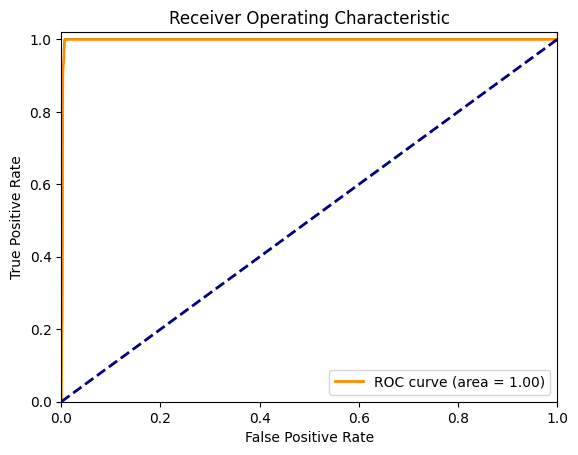

In [31]:
plot_roc_curve(y_val, y_val_pred_prob)

Let's also take a look at precission-recall curve and the AUC score.

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_test: np.array, y_pred_prob: np.array) -> None:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)

    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision:0.2f})')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.show()

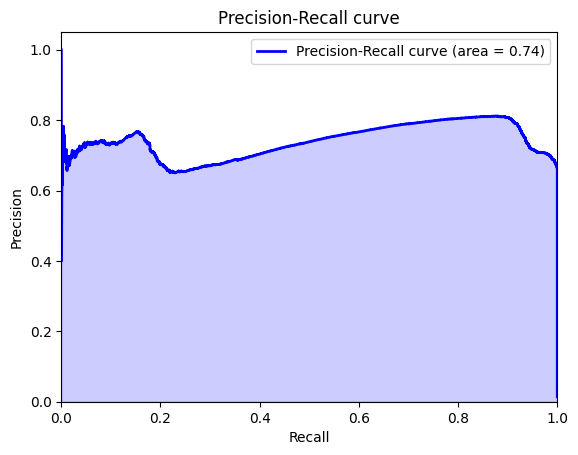

In [33]:
plot_precision_recall_curve(y_val, y_val_pred_prob)

The results from the ROC curve and the precision-recall curve are also good.

Now let's deep into the model to see the coefficients of the features and the intercept.

In [34]:
model.coef_

array([[ 7.7862246 ,  1.14293124, -0.33364696, -1.61620721,  0.55520668,
        -0.15390035,  1.14862638, -0.21810706]])

In [35]:
import statsmodels.api as sm

X_sm = sm.add_constant(X_train)
model_statmodels = sm.Logit(y_train, X_sm)
result_statmodels = model_statmodels.fit()
print(result_statmodels.summary())


Optimization terminated successfully.
         Current function value: 0.017562
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               641048
Model:                          Logit   Df Residuals:                   641039
Method:                           MLE   Df Model:                            8
Date:                Tue, 06 Feb 2024   Pseudo R-squ.:                  0.7553
Time:                        23:51:26   Log-Likelihood:                -11258.
converged:                       True   LL-Null:                       -46010.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                

Lastly, we can use the f1-score to evaluate the model. We can use the `f1_score` method from the `sklearn` library to do this.

In [36]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_prob)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_f1_index = np.argmax(f1_scores) # finds the index of the maximum F1 score

best_threshold = thresholds[best_f1_index]

print('Best threshold:', best_threshold)


Best threshold: 0.571957663872962


Now it's time to evaluate the model using the test set. We are changing the threshold to the one we got previously, which is the value that maximizes the f1-score.

In [37]:
y_test_pred = model.predict(X_test)
y_test_prob_pred = model.predict_proba(X_test)[:, 1]

In [38]:
y_test_pred = [1 if prob > best_threshold else 0 for prob in y_test_prob_pred]

We can use the same metrics to evaluate the model using the test set.

In [41]:
print_metrics(y_test, y_test_pred)

Accuracy: 0.9956914892261751
Confusion Matrix:
 [[385821   1247]
 [   444   4967]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    387068
         1.0       0.80      0.92      0.85      5411

    accuracy                           1.00    392479
   macro avg       0.90      0.96      0.93    392479
weighted avg       1.00      1.00      1.00    392479



It seems that the model is performing well in the test set too.
We have even improved a little the metrics from the previous evaluation using a different threshold.

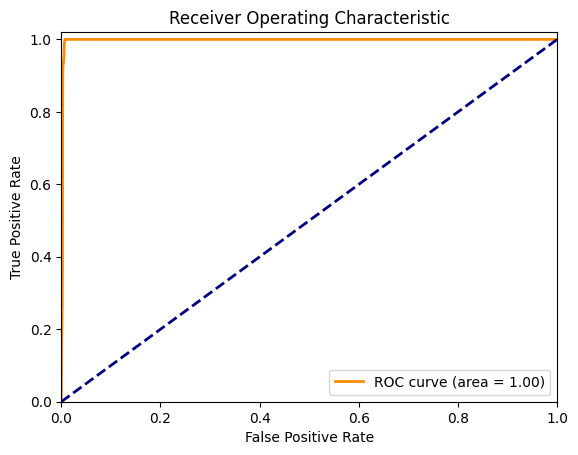

In [42]:
plot_roc_curve(y_test, y_test_prob_pred)

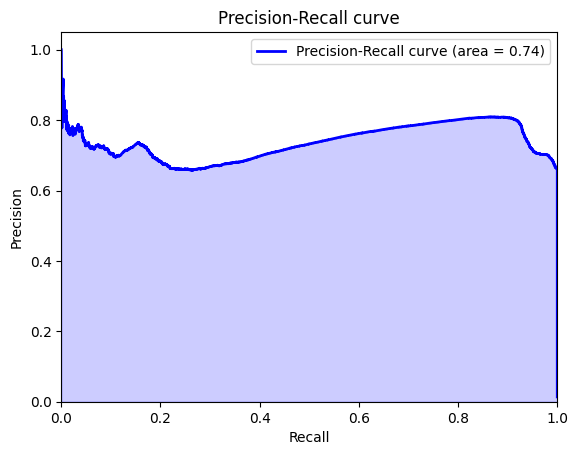

In [44]:
plot_precision_recall_curve(y_test, y_test_prob_pred)

## Conclusion

As a conclusion, we can say that the model is performing well. 
We have used the features that we mentioned before and we have evaluated the model using the training, validation and test sets. 

The model is predicting the outcome correctly in 99% of the cases and the f1-score is around 0.85, which is not bad. 
We can say that the model is performing well and we can use it to predict if a user would buy a product or not.